# Frequency correlation plots for natural populations with nested clades from a full tree

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [2]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [3]:
sns.set_style("white")
plt.style.use("huddlej")

In [4]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [5]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [6]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] < freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] < freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [7]:
min_clade_frequency = 0.15

In [8]:
precision = 4

In [9]:
data_root = "../results/builds/natural/natural_sample_1_with_90_vpm_sliding"

In [10]:
data_root_full_tree = "../results/builds/natural/natural_sample_1_with_90_vpm_sliding_full_tree"

In [11]:
first_validation_timepoint = "2003-10-01"

In [12]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [13]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [14]:
#tips = np.round(tips, precision)

In [15]:
np.round(tips.head(1), precision)

,strain,timepoint,frequency
1971,A/Alaska/17/2003,2003-10-01,0.0001


In [16]:
(tips["frequency"] > 0).sum()

13817

In [17]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root_full_tree, sep="\t",
                             usecols=["tip", "clade_membership", "depth"])

In [18]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [19]:
tips_to_clades.head(20)

,strain,clade_membership,depth
0,A/Oviedo/31/1992,f719ed0,0
1,A/Oviedo/31/1992,da3b22d,2
2,A/Nijmegen/3129/1992,f719ed0,0
3,A/Nijmegen/3129/1992,da3b22d,3
4,A/Netherlands/891/1991,f719ed0,0
5,A/Netherlands/891/1991,da3b22d,3
6,A/Paris/583/1992,56b7cc4,0
7,A/Paris/583/1992,da3b22d,2
8,A/Netherlands/935/1992,3674bd3,0
9,A/Netherlands/935/1992,56b7cc4,2


In [20]:
tips_to_clades.shape

(617460, 3)

In [21]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [22]:
#forecasts = np.round(forecasts, precision)

In [23]:
np.round(forecasts.head(1), 4)

,timepoint,strain,frequency,projected_frequency
0,1996-10-01,A/Fujian/126/1996,0.0044,0.0143


In [24]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [25]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [26]:
#full_forecasts = np.round(full_forecasts, precision)

In [27]:
full_forecasts.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
1971,2003-10-01,A/Alaska/17/2003,0.000089,16.009253,17.584641,-0.404540,0.000022,15.998975,2004-10-01
1972,2003-10-01,A/Alaska/AK-V03-1257/2003,0.003066,19.602892,19.669335,-0.877438,0.000469,19.903079,2004-10-01
1973,2003-10-01,A/Alaska/AK-V03-708/2003,0.000089,16.009253,17.584641,-0.404540,0.000022,15.998975,2004-10-01
1974,2003-10-01,A/Anhui/318/2003,0.003663,9.363720,7.813836,-2.004048,0.000181,9.102362,2004-10-01
1975,2003-10-01,A/Anhui/467/2003,0.005841,9.795141,8.308792,-2.305196,0.000214,9.271581,2004-10-01


## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [28]:
tips.head()

,strain,timepoint,frequency
1971,A/Alaska/17/2003,2003-10-01,0.000089
1972,A/Alaska/AK-V03-1257/2003,2003-10-01,0.003066
1973,A/Alaska/AK-V03-708/2003,2003-10-01,0.000089
1974,A/Anhui/318/2003,2003-10-01,0.003663
1975,A/Anhui/467/2003,2003-10-01,0.005841


In [29]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["strain"]
)

In [30]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency
0,A/NewYork/197/2003,bc28593,0,2003-10-01,0.000026
1,A/NewYork/197/2003,d6a7721,2,2003-10-01,0.000026
2,A/NewYork/197/2003,98894e8,3,2003-10-01,0.000026
3,A/NewYork/197/2003,05a6dc1,5,2003-10-01,0.000026
4,A/NewYork/197/2003,7dfbda8,9,2003-10-01,0.000026


In [31]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [32]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
0,A/NewYork/197/2003,bc28593,0,2003-10-01,0.000026,2004-10-01
1,A/NewYork/197/2003,d6a7721,2,2003-10-01,0.000026,2004-10-01
2,A/NewYork/197/2003,98894e8,3,2003-10-01,0.000026,2004-10-01
3,A/NewYork/197/2003,05a6dc1,5,2003-10-01,0.000026,2004-10-01
4,A/NewYork/197/2003,7dfbda8,9,2003-10-01,0.000026,2004-10-01


In [33]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [34]:
initial_clade_frequencies.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2003-10-01,2004-10-01,015478d,0.006687
1,2003-10-01,2004-10-01,0252ba2,0.050291
2,2003-10-01,2004-10-01,02e323e,0.999995
3,2003-10-01,2004-10-01,048f8ca,0.999995
4,2003-10-01,2004-10-01,0494631,0.000051


In [35]:
initial_clade_frequencies.query("clade_membership == '8517059'")

,timepoint,future_timepoint,clade_membership,frequency
627,2005-10-01,2006-10-01,8517059,0.017028
769,2006-04-01,2007-04-01,8517059,0.286684
897,2006-10-01,2007-10-01,8517059,0.294691
1027,2007-04-01,2008-04-01,8517059,0.009279
1177,2007-10-01,2008-10-01,8517059,0.000287


Merge clade frequencies between adjacent years.

In [36]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [37]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final
0,2003-10-01,02e323e,0.999995,1.000004
1,2003-10-01,048f8ca,0.999995,1.000004
2,2003-10-01,09e68a2,0.999995,1.000004
3,2003-10-01,1523083,0.009504,0.000059
4,2003-10-01,1b326c6,0.999995,1.000004


In [38]:
initial_and_observed_clade_frequencies.query("clade_membership == 'cb64469'")

,timepoint,clade_membership,frequency,frequency_final


Select clades with an initial frequency >10%.

In [39]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > %s" % min_clade_frequency).copy()

In [40]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final
0,2003-10-01,02e323e,0.999995,1.000004
1,2003-10-01,048f8ca,0.999995,1.000004
2,2003-10-01,09e68a2,0.999995,1.000004
4,2003-10-01,1b326c6,0.999995,1.000004
5,2003-10-01,1c5e069,0.949704,1.000004


In [41]:
large_clades.tail()

,timepoint,clade_membership,frequency,frequency_final
1663,2014-10-01,f14fabc,0.222049,0.886460
1664,2014-10-01,f2ec31a,0.999986,0.999999
1665,2014-10-01,f3f16af,0.999986,0.999999
1667,2014-10-01,f8b8996,0.999986,0.999999
1669,2014-10-01,fd5608c,0.999986,0.999999


In [42]:
large_clades.shape

(1107, 4)

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [43]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["strain"]
)

In [44]:
clade_tip_estimated_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
0,A/HongKong/434/1996,f8b9dde,0,1997-04-01,0.00055,0.000092
1,A/HongKong/434/1996,8e08f7f,3,1997-04-01,0.00055,0.000092
2,A/HongKong/434/1996,56aeb39,4,1997-04-01,0.00055,0.000092
3,A/HongKong/434/1996,b7fdf48,6,1997-04-01,0.00055,0.000092
4,A/HongKong/434/1996,36de0d1,7,1997-04-01,0.00055,0.000092


In [45]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [46]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency
0,1996-10-01,02e323e,0.999996
1,1996-10-01,03a9264,0.000966
2,1996-10-01,048f8ca,0.025186
3,1996-10-01,09e68a2,0.078409
4,1996-10-01,0f08269,0.071122


In [47]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [48]:
complete_clade_frequencies = np.round(complete_clade_frequencies, 2)

In [49]:
complete_clade_frequencies = complete_clade_frequencies.query("frequency != frequency_final").copy()

In [50]:
complete_clade_frequencies.shape

(209, 5)

In [51]:
complete_clade_frequencies["observed_growth_rate"] = (
    complete_clade_frequencies["frequency_final"] / complete_clade_frequencies["frequency"]
)

In [52]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

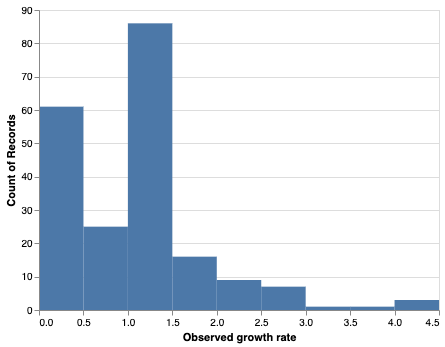

In [53]:
alt.Chart(complete_clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

In [54]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [55]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year
4,2003-10-01,1c5e069,0.95,1.00,0.99,1.052632,1.042105,2003
7,2003-10-01,4952842,0.90,0.97,0.98,1.077778,1.088889,2003
8,2003-10-01,4e35443,0.95,1.00,0.99,1.052632,1.042105,2003
10,2003-10-01,6335574,0.95,1.00,0.99,1.052632,1.042105,2003
11,2003-10-01,8386d16,0.95,1.00,0.99,1.052632,1.042105,2003


In [56]:
complete_clade_frequencies.shape

(209, 8)

In [57]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [58]:
r

0.7236046217504225

In [59]:
p

3.5627923889199e-35

In [60]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [61]:
mcc

0.724095164365373

In [62]:
confusion_matrix

{'tp': 116, 'tn': 55, 'fp': 18, 'fn': 7}

In [63]:
sum(confusion_matrix.values())

196

In [64]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.8656716417910447

In [65]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.8870967741935484

In [66]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [67]:
pseudofrequency = 0.001

In [68]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

In [69]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate
4,2003-10-01,1c5e069,0.95,1.00,0.99,1.052632,1.042105,2003,0.022254,0.017893
7,2003-10-01,4952842,0.90,0.97,0.98,1.077778,1.088889,2003,0.032494,0.036944
8,2003-10-01,4e35443,0.95,1.00,0.99,1.052632,1.042105,2003,0.022254,0.017893
10,2003-10-01,6335574,0.95,1.00,0.99,1.052632,1.042105,2003,0.022254,0.017893
11,2003-10-01,8386d16,0.95,1.00,0.99,1.052632,1.042105,2003,0.022254,0.017893


In [70]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

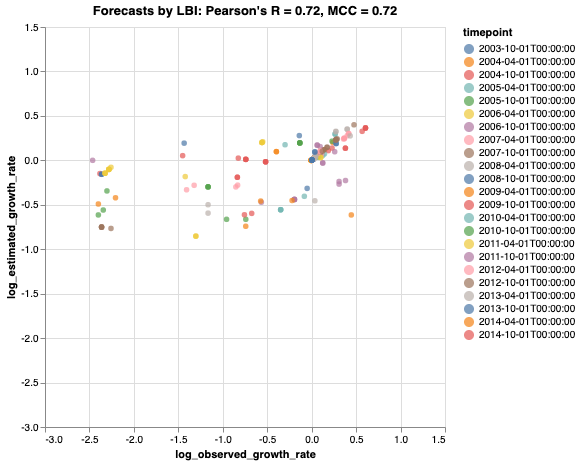

In [71]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
).interactive()

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [72]:
log_lower_limit

-2.5638929889859075

In [73]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.4638929889859074

In [74]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [75]:
r

0.5956388284880263

In [76]:
p

1.8582955491895612e-21

In [77]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(0.7236046217504225, 3.5627923889199e-35)

In [78]:
complete_clade_frequencies["observed_growth"] = (complete_clade_frequencies["observed_growth_rate"] > 1)

In [79]:
complete_clade_frequencies["estimated_growth"] = (complete_clade_frequencies["estimated_growth_rate"] > 1)

In [80]:
complete_clade_frequencies["accurate_growth"] = (
    (complete_clade_frequencies["observed_growth"]) == (complete_clade_frequencies["estimated_growth"])
)

In [81]:
confusion_matrix

{'tp': 116, 'tn': 55, 'fp': 18, 'fn': 7}

In [82]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
4,2003-10-01,1c5e069,0.95,1.00,0.99,1.052632,1.042105,2003,0.022254,0.017893,True,True,True
7,2003-10-01,4952842,0.90,0.97,0.98,1.077778,1.088889,2003,0.032494,0.036944,True,True,True
8,2003-10-01,4e35443,0.95,1.00,0.99,1.052632,1.042105,2003,0.022254,0.017893,True,True,True
10,2003-10-01,6335574,0.95,1.00,0.99,1.052632,1.042105,2003,0.022254,0.017893,True,True,True
11,2003-10-01,8386d16,0.95,1.00,0.99,1.052632,1.042105,2003,0.022254,0.017893,True,True,True


In [83]:
(complete_clade_frequencies["estimated_growth_rate"] > 1).sum()

134

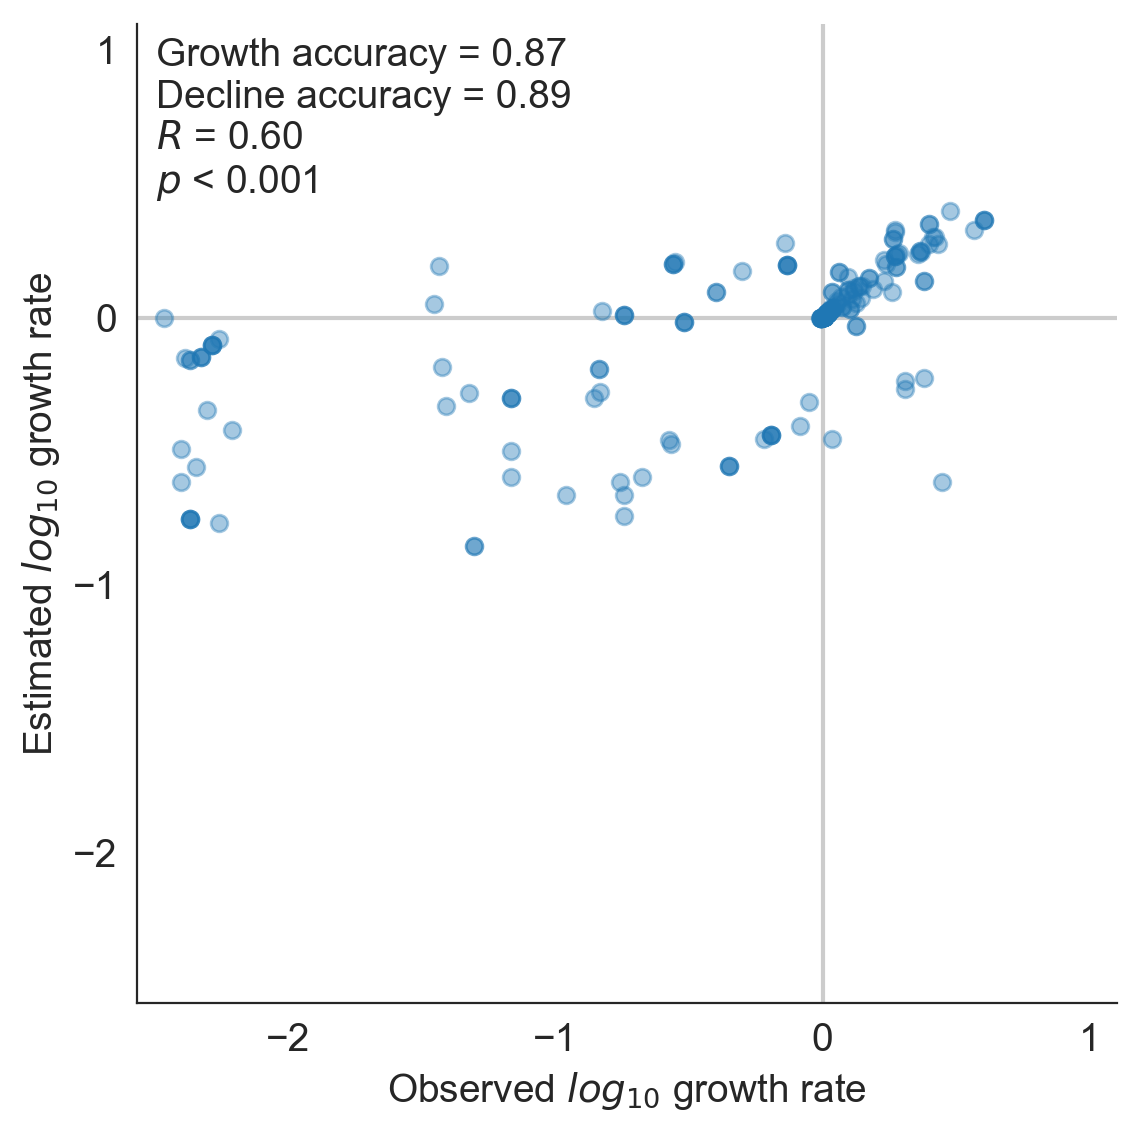

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=14,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations-by-clade-growth.png")

In [85]:
false_positives = (complete_clade_frequencies["log_observed_growth_rate"] < 0) & (complete_clade_frequencies["log_estimated_growth_rate"] > 0)

In [86]:
confusion_matrix

{'tp': 116, 'tn': 55, 'fp': 18, 'fn': 7}

In [87]:
complete_clade_frequencies[false_positives].sort_values("frequency")

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
557,2010-04-01,7fba9ff,0.26,0.13,0.39,0.500000,1.500000,2010,-0.299369,0.175536,False,True,False
532,2009-10-01,e62a2e8,0.31,0.01,0.35,0.032258,1.129032,2009,-1.451368,0.052547,False,True,False
1068,2014-10-01,80897ab,0.34,0.05,0.36,0.147059,1.058824,2014,-0.825184,0.024753,False,True,False
1092,2014-10-01,c9346ca,0.39,0.07,0.40,0.179487,1.025641,2014,-0.740918,0.010968,False,True,False
1050,2014-10-01,1edac85,0.39,0.07,0.40,0.179487,1.025641,2014,-0.740918,0.010968,False,True,False
1048,2014-10-01,1ba36d2,0.39,0.07,0.40,0.179487,1.025641,2014,-0.740918,0.010968,False,True,False
928,2013-10-01,1a16e36,0.40,0.29,0.76,0.725000,1.900000,2013,-0.139251,0.278240,False,True,False
587,2010-10-01,026d21f,0.49,0.36,0.77,0.734694,1.571429,2010,-0.133574,0.195973,False,True,False
602,2010-10-01,4786bbf,0.49,0.36,0.77,0.734694,1.571429,2010,-0.133574,0.195973,False,True,False
622,2010-10-01,a08d8f5,0.49,0.36,0.77,0.734694,1.571429,2010,-0.133574,0.195973,False,True,False


## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [88]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [89]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [100]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "y"],
    ascending=True
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [101]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2003-10-01,0.413095
1,2004-04-01,0.093074
2,2004-10-01,0.153179
3,2005-04-01,0.136761
4,2005-10-01,0.127932


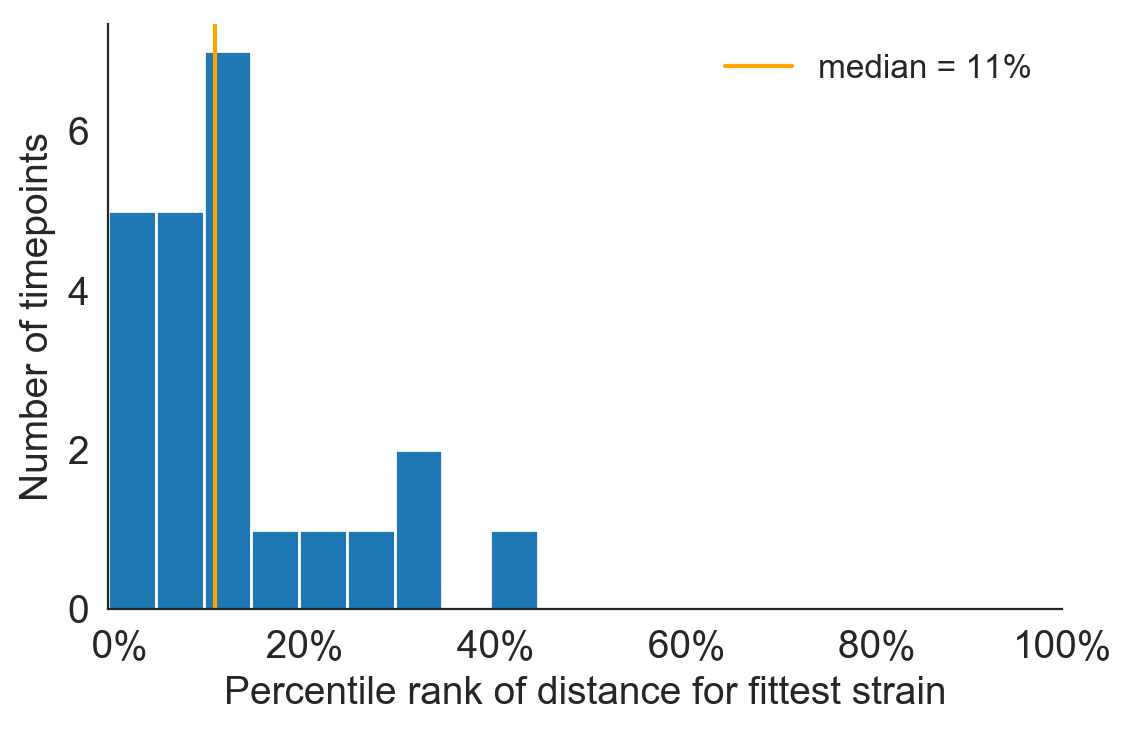

In [102]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank of distance for fittest strain")
ax.set_ylabel("Number of timepoints")

plt.tight_layout()
plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations-by-best-strain.png")

## Merge validation figures into subpanels of one figure

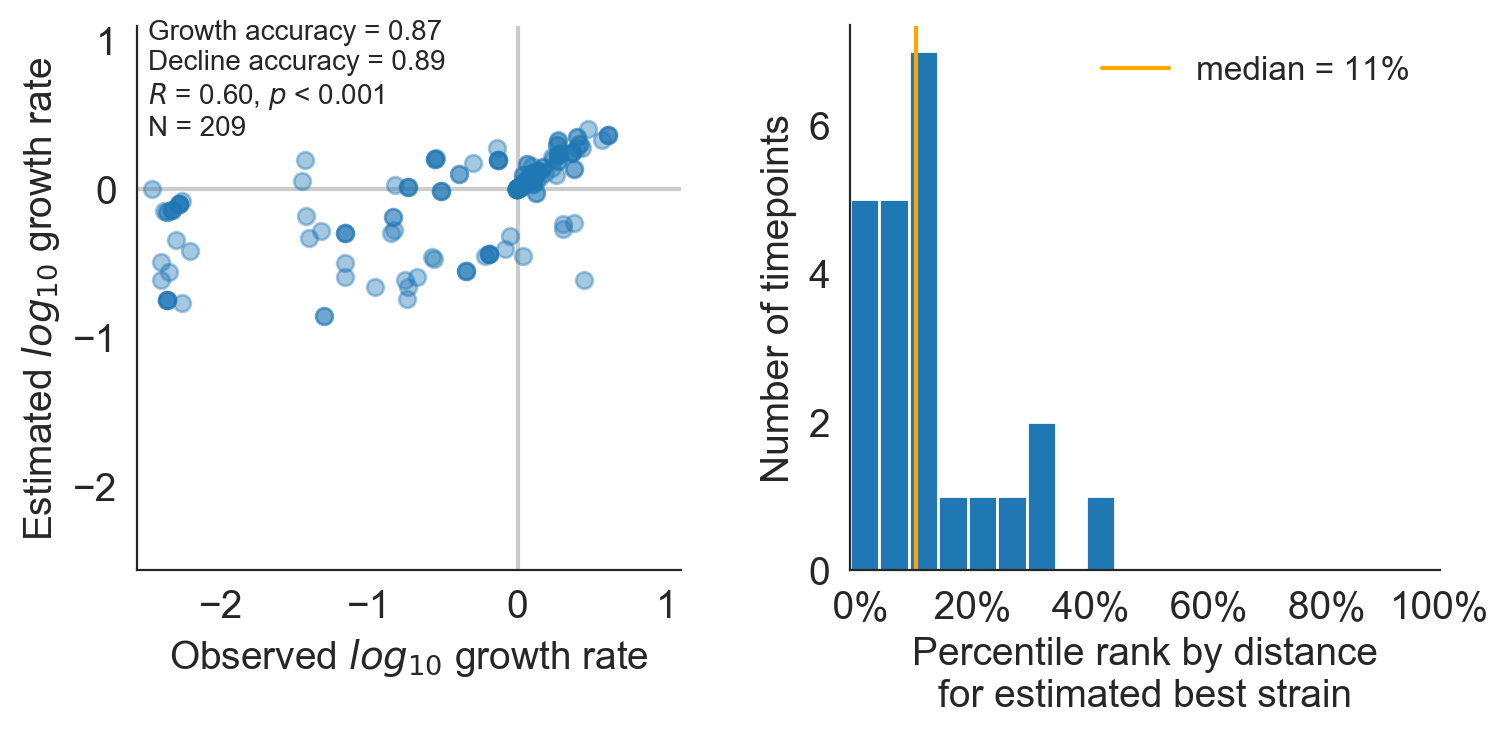

In [103]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f, %s\nN = %s" % (growth_accuracy, decline_accuracy, r, p_value, complete_clade_frequencies.shape[0]),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.png")

In [104]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] < 0.2).sum()

18

In [105]:
best_fitness_rank_by_timepoint_df.shape

(23, 2)

In [106]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.782608695652174

## Inspect uncertainty in forecast accuracy

Use observed forecasting errors to inspect the accuracy of one-year lookaheads based on the initial frequency of each clade.

In [97]:
complete_clade_frequencies.shape

(209, 13)

In [98]:
complete_clade_frequencies["clade_error"] = complete_clade_frequencies["frequency_final"] - complete_clade_frequencies["projected_frequency"]

Text(0,0.5,'Forecast error (%)')

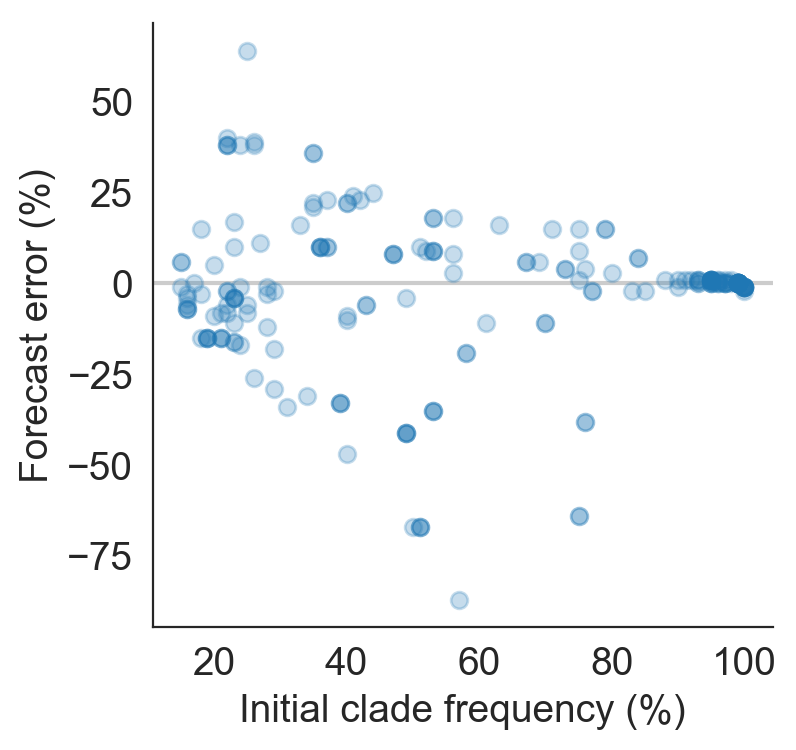

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(
    complete_clade_frequencies["frequency"].values * 100,
    complete_clade_frequencies["clade_error"].values * 100,
    "o",
    alpha=0.25
)
ax.axhline(0, color="#cccccc", zorder=-10)
ax.set_xlabel("Initial clade frequency (%)")
ax.set_ylabel("Forecast error (%)")